In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Example: Unzip into the current working directory - since i have a zip in my drive and i want to unzip into my colab env for faster access
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.0 MB/s eta 0:00:00


In [ ]:
# Standard Library Imports
import os
import random
import shutil
import warnings
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
# Image Processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import rasterio
from PIL import Image
import PIL
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import AdamW
import keras_cv
keras.mixed_precision.set_global_policy("mixed_float16")
# Progress Bars
import tqdm
from tqdm.auto import trange, tqdm
# Evaluation Metrics
import sklearn
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend


In [ ]:
IMAGE_SIZE = (260,260) #For EfficentNetV2B2
BATCH_SIZE = 32
COLOR_MODE = "rgb"
SHUFFLE = True
TRAIN_PATH = "/content/dataset/"
SEED = 4224
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 4
NUM_EPOCHS = 50
INITIAL_LEARNING_RATE = 0.0001

In [ ]:
IMAGE_SIZE

(260, 260)

In [ ]:
# Function to split data
def split_data(path, seed, test_size=0.1, val_size=0.2):
    all_files = []
    all_labels = []

    # Iterate through directory and collect file paths and labels
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                img_path = os.path.join(class_path, img)
                all_files.append(img_path)
                all_labels.append(class_dir)

    # Convert labels to numeric format
    label_to_index = {label: index for index, label in enumerate(np.unique(all_labels))}
    all_labels = [label_to_index[label] for label in all_labels]

    # Split into train+val and test
    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=seed, stratify=all_labels
    )

    # Split train+val into train and validation sets
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_val_files, train_val_labels, test_size=val_size, random_state=seed, stratify=train_val_labels
    )

    return (train_files, train_labels), (val_files, val_labels), (test_files, test_labels)

# Helper function to create datasets from file paths and labels
def create_dataset(files, labels, imgsz, bsz, clr, shuffle, seed):
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(files), seed=seed)
    dataset = dataset.map(lambda x, y: (load_image(x, imgsz, clr), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(bsz).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Load image utility function
def load_image(file_path, imgsz, clr):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3 if clr == "rgb" else 1)
    image = tf.image.resize(image, imgsz)
    # normalization
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and split the data
(train_files, train_labels), (val_files, val_labels), (test_files, test_labels) = split_data(TRAIN_PATH, SEED)

# Create datasets
train_batch = create_dataset(train_files, train_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, SHUFFLE, SEED)
val_batch = create_dataset(val_files, val_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, False, SEED)
test_batch = create_dataset(test_files, test_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, False, SEED)


In [ ]:
def augment_img(img_, lbl_):
    image = tf.image.random_flip_left_right(img_)
    image = tf.image.central_crop(image, 0.85)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    return tf.cast(image, tf.float32), lbl_

train_batch = train_batch.map(augment_img, tf.data.AUTOTUNE)
train_batch = train_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_batch = test_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(val_batch) * BATCH_SIZE

2048

Coccidiosis Percentage: 25.00%
Healthy Percentage: 25.00%
Newcastle Disease Percentage: 25.00%
Salmo Percentage: 25.00%


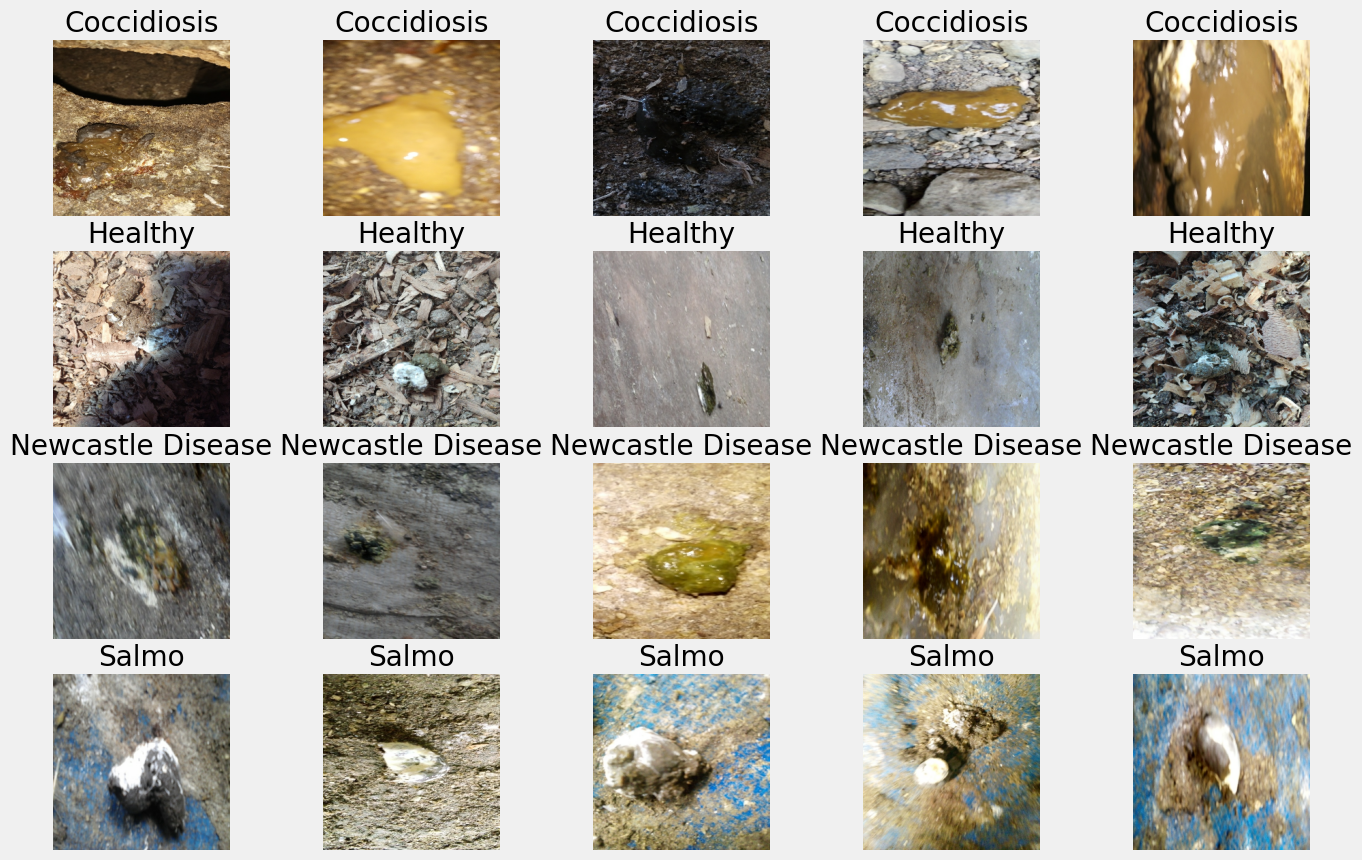

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def val_batch_class_distribution(valid_batch):
    images = []
    labels = []

    for img, lbl in valid_batch.unbatch():
        images.append(img.numpy())
        if lbl == 0:
            labels.append("Coccidiosis")
        elif lbl == 1:
            labels.append("Healthy")
        elif lbl == 2:
            labels.append("Newcastle Disease")
        else:
            labels.append("Salmo")

    images = np.array(images)
    labels = np.array(labels)

    coccidiosis_pct = np.mean(labels == "Coccidiosis")
    healthy_pct = np.mean(labels == "Healthy")
    newcastle_pct = np.mean(labels == "Newcastle Disease")
    salmo_pct = np.mean(labels == "Salmo")

    print(f'Coccidiosis Percentage: {coccidiosis_pct * 100:.2f}%')
    print(f'Healthy Percentage: {healthy_pct * 100:.2f}%')
    print(f'Newcastle Disease Percentage: {newcastle_pct * 100:.2f}%')
    print(f'Salmo Percentage: {salmo_pct * 100:.2f}%')

    return images, labels

def visualize_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name][:num_images]
        for j, img in enumerate(class_images):
            plt.subplot(len(class_names), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Get images and labels from the validation batch
images, labels = val_batch_class_distribution(val_batch)

# Define class names
class_names = ["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"]

# Visualize images
visualize_images(images, labels, class_names)


In [ ]:
def create_efficient_model():
  # LINK: https://keras.io/api/keras_cv/models/backbones/efficientnet_v2/#efficientnetv2b2backbone-class
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
        # Use efficientnetv2_b2_imagenet or efficientnetv2_b2
        "efficientnetv2_b2_imagenet",
        activation="relu",
        # the suitable input shape: https://www.kaggle.com/models/google/efficientnet-v2
        # 260,260 is recommneded
        input_shape=(260, 260, 3),
        include_rescaling = False,
        load_weights = True
    )
    # TODO: Comment the below line if performing bad.
    # backbone.trainable = False

    model = keras_cv.models.ImageClassifier(
        backbone=backbone,
        num_classes=NUM_CLASSES,
        activation = "softmax",
        name = "KerasCV_efficientnet"
    )
    # TODO: Uncomment the below line if performing bad.
    model.trainable = True

    initial_learning_rate = INITIAL_LEARNING_RATE
    optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)

    model.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model

In [ ]:
efficient_model = create_efficient_model()

100%|██████████| 1.79k/1.79k [00:00<00:00, 2.19MB/s]


100%|██████████| 34.2M/34.2M [00:03<00:00, 9.58MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


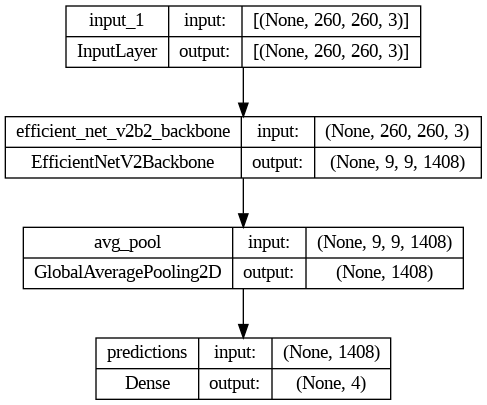

In [ ]:
keras.utils.plot_model(efficient_model, to_file = "efficientnetv2B2_model_architecture.png", show_shapes = True)

In [ ]:
efficient_model.summary()

Model: "KerasCV_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 260, 260, 3)]     0         
                                                                 
 efficient_net_v2b2_backbon  (None, 9, 9, 1408)        8769374   
 e (EfficientNetV2Backbone)                                      
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1408)              0         
 ling2D)                                                         
                                                                 
 predictions (Dense)         (None, 4)                 5636      
                                                                 
Total params: 8775010 (33.47 MB)
Trainable params: 8692722 (33.16 MB)
Non-trainable params: 82288 (321.44 KB)
_________________________________________________________________


In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

In [ ]:
def fit_model_and_save_logs(model, name:str, train_, valid_, test_):
    # Define callbacks
    es_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='auto',
        restore_best_weights=True
    )
    lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_best_model.h5",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    csv_log = keras.callbacks.CSVLogger(
        filename = f"{name}_logs.csv",
        separator = ","
    )

    model.fit(
        train_,
        validation_data = valid_,
        callbacks = [es_cb, lr_cb, csv_log, checkpoint_cb],
        verbose = 2,
        epochs = NUM_EPOCHS,
    )

    # Initialize metrics list
    metrics = []

    # Extract true labels from the validation and test dataset
    true_val_values = [y for x, y in valid_.unbatch()]
    true_test_values = [y.numpy() for x, y in test_.unbatch()]

    # Convert history to a DataFrame for easier plotting
    history_df = pd.DataFrame(model.history.history)
    # Plot accuracy and loss
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6), sharey = False)
    history_df[["accuracy", "val_accuracy"]].plot(ax = ax[0], title = "Accuracy vs Validation Accuracy", lw = 2)
    history_df[["loss", "val_loss"]].plot(ax = ax[1], title = "Loss vs Validation Loss", lw = 1.7)
    plt.savefig(f"{name}_train_val.png")

    # Predict on validation and test data
    val_preds = model.predict(valid_, verbose=2)
    val_preds = np.argmax(val_preds, axis=1)

    test_preds = model.predict(test_, verbose=2)
    test_preds = np.argmax(test_preds, axis=1)

    # Calculate metrics for validation data
    val_accuracy = accuracy_score(true_val_values, val_preds) * 100
    val_precision = precision_score(true_val_values, val_preds, average="weighted") * 100
    val_f1 = f1_score(true_val_values, val_preds, average="weighted") * 100
    val_recall = recall_score(true_val_values, val_preds, average="weighted") * 100

    # Calculate metrics for test data
    test_accuracy = accuracy_score(true_test_values, test_preds) * 100
    test_precision = precision_score(true_test_values, test_preds, average="weighted") * 100
    test_f1 = f1_score(true_test_values, test_preds, average="weighted") * 100
    test_recall = recall_score(true_test_values, test_preds, average="weighted") * 100

    # Store metrics in the list
    metrics.extend([val_accuracy, val_precision, val_f1, val_recall, test_accuracy, test_precision, test_f1, test_recall])

    # Classification report for validation data
    val_cr = classification_report(true_val_values, val_preds, output_dict=True)
    val_cr_df = pd.DataFrame(val_cr).transpose()
    val_cr_df.to_csv(f"{name}_val_classification_report.csv", index=True)

    # Classification report for test data
    test_cr = classification_report(true_test_values, test_preds, output_dict=True)
    test_cr_df = pd.DataFrame(test_cr).transpose()
    test_cr_df.to_csv(f"{name}_test_classification_report.csv", index=True)

    # # Confusion matrix for validation data
    conf_matrix = confusion_matrix(true_val_values, val_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"], yticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Validation Confusion Matrix')
    plt.savefig(f"{name}_val_confusion_matrix.jpg")
    plt.show()


    # Confusion matrix for test data
    conf_matrix = confusion_matrix(true_test_values, test_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"], yticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Test Confusion Matrix')
    plt.savefig(f"{name}_test_confusion_matrix.jpg")
    plt.show()

    # Metric DataFrame
    metric_dataframe = pd.DataFrame(
        data={"metrics": ["Val_Accuracy", "Val_Precision", "Val_F1_Score", "Val_Recall",
                          "Test_Accuracy", "Test_Precision", "Test_F1_Score", "Test_Recall"],
              "score": metrics,
              "name": [f"{name}"] * 8}
    )

    return metric_dataframe

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.92171, saving model to efficientnetV2B2_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 131s - loss: 0.6180 - accuracy: 0.7845 - val_loss: 0.2266 - val_accuracy: 0.9217 - lr: 1.0000e-04 - 131s/epoch - 467ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.92171 to 0.94528, saving model to efficientnetV2B2_best_model.h5
281/281 - 52s - loss: 0.1883 - accuracy: 0.9391 - val_loss: 0.1523 - val_accuracy: 0.9453 - lr: 1.0000e-04 - 52s/epoch - 185ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.94528 to 0.94884, saving model to efficientnetV2B2_best_model.h5
281/281 - 52s - loss: 0.1192 - accuracy: 0.9625 - val_loss: 0.1402 - val_accuracy: 0.9488 - lr: 1.0000e-04 - 52s/epoch - 186ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.94884 to 0.95907, saving model to efficientnetV2B2_best_model.h5
281/281 - 52s - loss: 0.0810 - accuracy: 0.9759 - val_loss: 0.1249 - val_accuracy: 0.9591 - lr: 1.0000e-04 - 52s/epoch - 187ms/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.95907
281/281 - 52s - loss: 0.0571 - accuracy: 0.9829 - val_loss: 0.

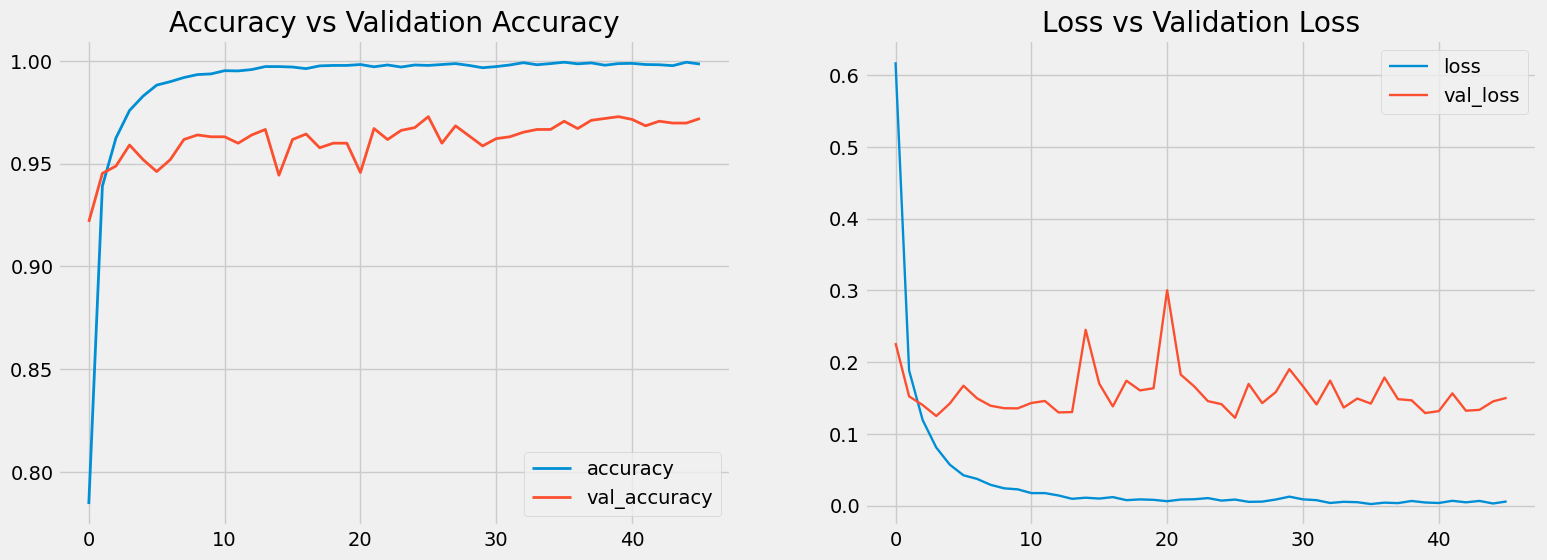

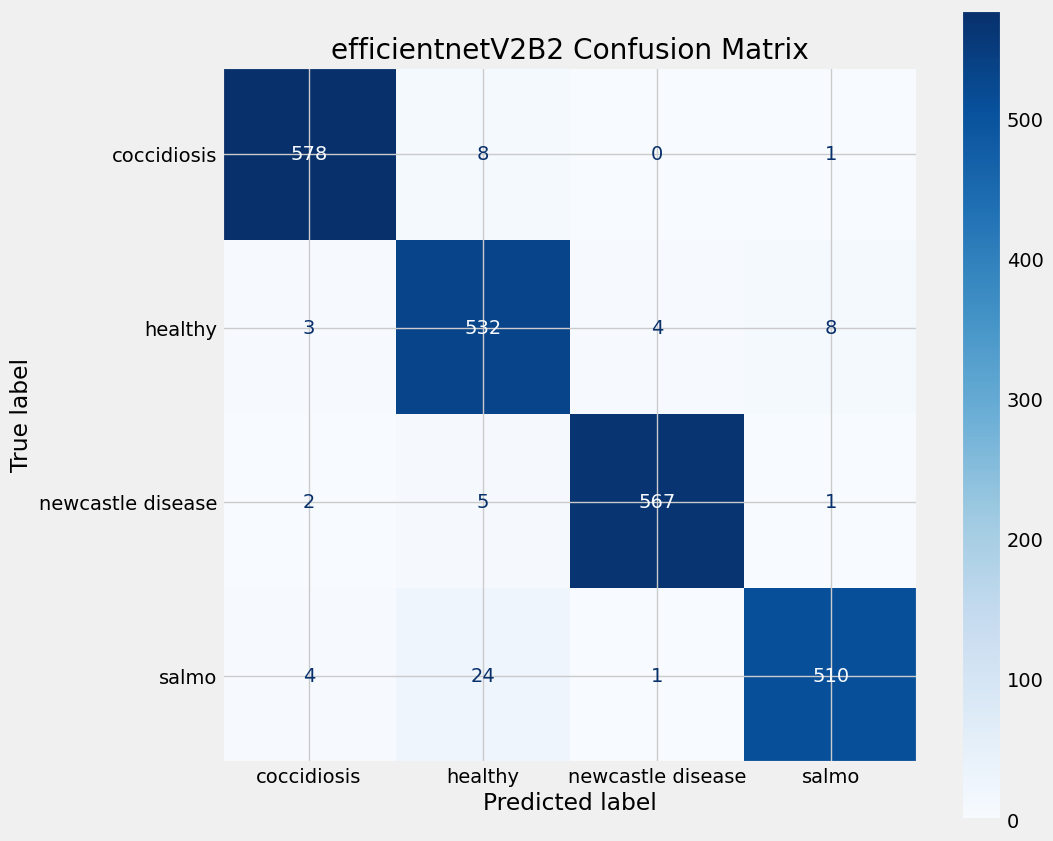

In [ ]:
# with imagenet weights
en_metric_df_V2_B2_imagenet_1 = fit_model_and_save_logs(efficient_model, "efficientnetV2B2", train_batch, val_batch)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.22496, saving model to efficientnetV2B2_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 - 135s - loss: 0.6621 - accuracy: 0.7730 - val_loss: 0.2250 - val_accuracy: 0.9269 - lr: 1.0000e-04 - 135s/epoch - 535ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.22496 to 0.15874, saving model to efficientnetV2B2_best_model.h5
253/253 - 47s - loss: 0.2038 - accuracy: 0.9322 - val_loss: 0.1587 - val_accuracy: 0.9452 - lr: 1.0000e-04 - 47s/epoch - 185ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.15874 to 0.13828, saving model to efficientnetV2B2_best_model.h5
253/253 - 47s - loss: 0.1270 - accuracy: 0.9584 - val_loss: 0.1383 - val_accuracy: 0.9516 - lr: 1.0000e-04 - 47s/epoch - 185ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.13828
253/253 - 46s - loss: 0.0905 - accuracy: 0.9695 - val_loss: 0.1388 - val_accuracy: 0.9550 - lr: 1.0000e-04 - 46s/epoch - 181ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.13828 to 0.13163, saving model to efficientnetV2B2_best_model.h5
253/253 - 47s - loss: 0.0609 - accuracy: 0.9829 - val_loss: 0.1316 - val_accur

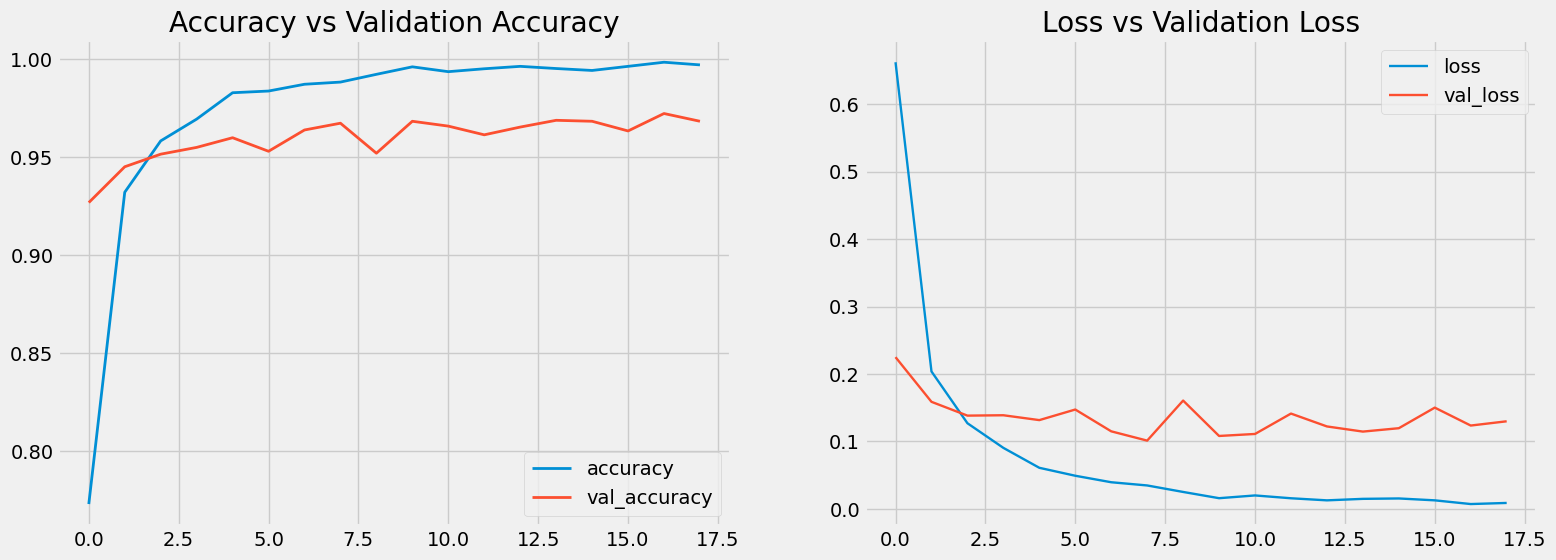

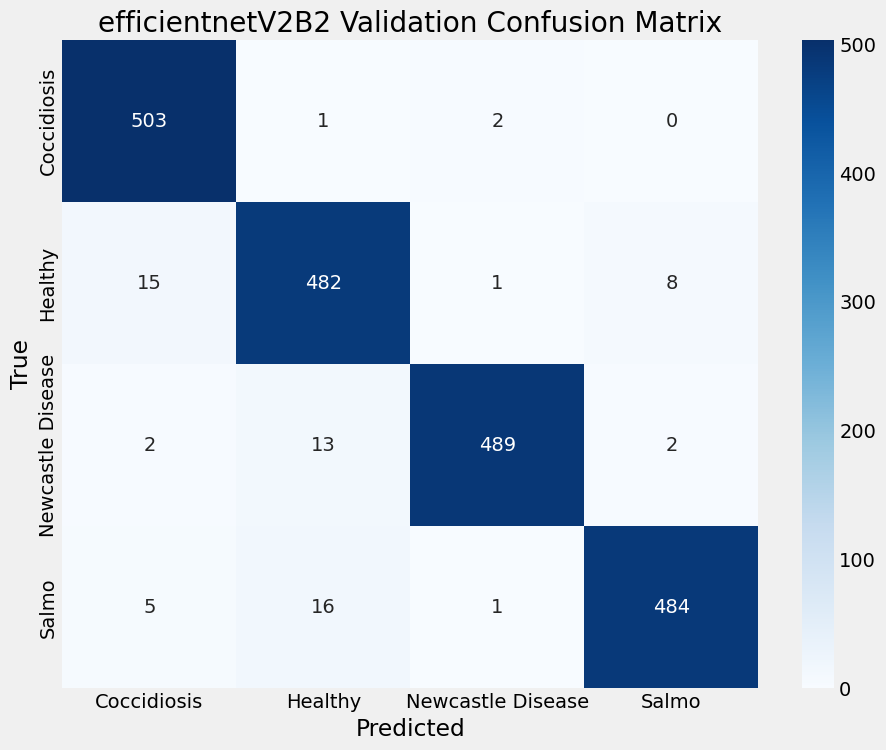

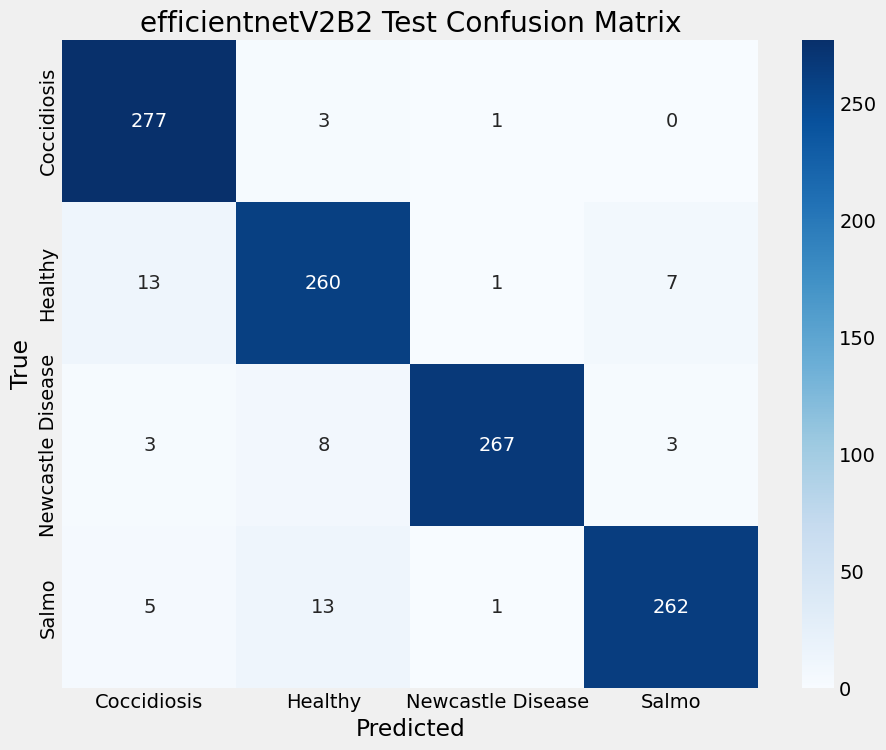

In [ ]:
# with imagenet weights
# monitor val loss - patience ES 10 and RP 5
en_metric_df_V2_B2_imagenet_2 = fit_model_and_save_logs(efficient_model, "efficientnetV2B2", train_batch, val_batch, test_batch)

In [ ]:
mkdir output

In [ ]:
cp -r './output' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/4_efficientNetV2B2/2_output_stable_3_split'